NSL-KDD Multi-class 5
---

Accuracy: 0.9925193905271861

Precision: 0.9925327544029282

F1-score: 0.9925215669204571


#Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Data

In [2]:
features = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
            'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
            'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate',
            'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
            'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
            'dst_host_srv_rerror_rate','class','difficulty_level']

In [3]:
from google.colab import drive
drive.mount('/content/drive')
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDTrain+.txt", names = features)
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDTest+.txt", names = features)

print(train_df.shape)
print(test_df.shape)


Mounted at /content/drive
(125967, 43)
(22549, 43)


In [4]:
#combining train and test files (there's an error when doing the one hot encoding)
data = pd.concat([train_df, test_df])
print(data.shape)
data.head()

(148516, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [5]:
data.info()

""" 
  'protocol_type','srevice', 'flag' : categorical types
  'difficulty_level'                : usless
  'class'                           : has multiplie classes of attaks and a normal class
  
  'is_host_login','land', 'logged_in','is_guest_login' : binary no need for normalizing
"""

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148516 entries, 0 to 22548
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148516 non-null  int64  
 1   protocol_type                148516 non-null  object 
 2   service                      148516 non-null  object 
 3   flag                         148516 non-null  object 
 4   src_bytes                    148516 non-null  int64  
 5   dst_bytes                    148516 non-null  int64  
 6   land                         148516 non-null  int64  
 7   wrong_fragment               148516 non-null  int64  
 8   urgent                       148516 non-null  int64  
 9   hot                          148516 non-null  int64  
 10  num_failed_logins            148516 non-null  int64  
 11  logged_in                    148516 non-null  int64  
 12  num_compromised              148516 non-null  int64  
 13  

" \n  'protocol_type','srevice', 'flag' : categorical types\n  'difficulty_level'                : usless\n  'class'                           : has multiplie classes of attaks and a normal class\n  \n  'is_host_login','land', 'logged_in','is_guest_login' : binary no need for normalizing\n"

In [6]:
#some stats
data.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,difficulty_level
count,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000
mean,276.781168,40228.220165,17088.968657,0.000215,0.020523,0.000202,0.189380,0.004323,0.402792,0.255063,0.001508,0.000976,0.273728,0.012073,0.000525,0.004013,0.000000,0.000081,0.012308,83.333695,28.252121,0.256926,0.255339,0.137942,0.138481,0.672987,0.067755,0.097442,183.927563,119.463458,0.534524,0.084097,0.145933,0.030584,0.256123,0.251306,0.136215,0.136391,19.278495
std,2460.691310,5409629.816013,3703537.248657,0.014677,0.240070,0.019417,2.013167,0.072248,0.490461,22.231450,0.038807,0.042389,22.689100,0.517865,0.027701,0.095257,0.000000,0.008989,0.110259,116.755909,75.369855,0.431919,0.432579,0.339382,0.341777,0.436542,0.194651,0.258886,98.528487,111.232267,0.448061,0.194088,0.308638,0.108975,0.428501,0.429720,0.322736,0.335276,2.739760
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,87.000000,11.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,72.000000,0.600000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,278.000000,571.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,141.000000,17.000000,0.850000,0.910000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.050000,0.010000,0.600000,0.500000,0.000000,0.000000,21.000000
max,57715.000000,1379963888.000000,1309937401.000000,1.000000,3.000000,3.000000,101.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,100.000000,5.000000,9.000000,0.000000,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


### fixing labels

In [7]:
#Actual labels
print(data['class'].value_counts())

normal             77054
neptune            45871
satan               4367
ipsweep             3740
smurf               3311
portsweep           3088
nmap                1566
back                1315
guess_passwd        1284
mscan                996
warezmaster          964
teardrop             904
warezclient          890
apache2              737
processtable         685
snmpguess            331
saint                319
mailbomb             293
pod                  242
snmpgetattack        178
httptunnel           133
buffer_overflow       50
land                  25
multihop              25
rootkit               23
named                 17
ps                    15
sendmail              14
xterm                 13
imap                  12
loadmodule            11
ftp_write             11
xlock                  9
phf                    6
perl                   5
xsnoop                 4
spy                    2
worm                   2
sqlattack              2
udpstorm               2


In [8]:
#fixing labels

dos_class =["apache2","back","land","neptune","mailbomb","pod","processtable","smurf","teardrop","udpstorm","worm"]
R2L_class =["ftp_write","guess_passwd","imap","multihop","named","phf","sendmail","snmpgetattack","spy","snmpguess","warezclient","warezmaster","xlock","xsnoop"]      
Probe_class =["ipsweep","mscan","nmap","portsweep","saint","satan"]
U2R_class =["buffer_overflow","loadmodule","perl","ps","rootkit","sqlattack","xterm","httptunnel"]

for atk in dos_class:
  data.loc[data['class'] == atk, 'class'] = 'DoS'
for atk in R2L_class: 
  data.loc[data['class'] == atk, 'class'] = 'R2L'
for atk in Probe_class: 
  data.loc[data['class'] == atk, 'class'] = 'Probe'
for atk in U2R_class :
  data.loc[data['class'] == atk, 'class'] = "U2R"

data['class'].value_counts()


normal    77054
DoS       53387
Probe     14076
R2L        3747
U2R         252
Name: class, dtype: int64

##Data visualisation

###Repartition des classes


<Axes: ylabel='class'>

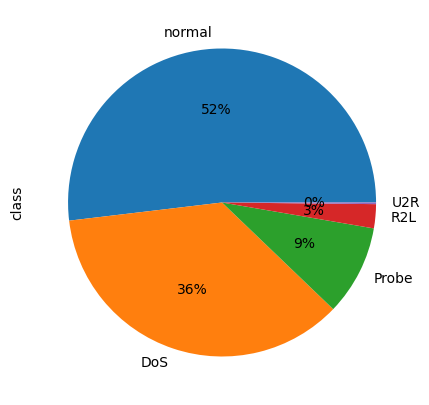

In [9]:
data['class'].value_counts().plot(kind = "pie" ,figsize=(5, 5), fontsize=10, autopct='%1.0f%%')

In [10]:
#data.plot(kind='box',subplots=True,layout=(6,8),figsize=(20,40))
plt.show()

# prétraitement



In [11]:
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22544,0,icmp,red_i,SF,91,0,0,0,0,0,...,0.01,0.02,0.01,0.00,0.00,0.00,0.11,0.00,normal,20
22545,0,icmp,urh_i,SF,36,0,0,0,0,0,...,0.14,0.07,0.14,0.00,0.00,0.00,0.00,0.00,normal,21
22546,0,tcp,http_8001,S0,0,0,0,0,0,0,...,0.00,1.00,0.00,0.00,0.13,1.00,0.87,0.00,Probe,17
22547,0,tcp,aol,REJ,0,0,0,0,0,0,...,0.00,1.00,0.00,0.00,0.03,0.00,0.97,1.00,Probe,17


##### 1-Normalisation (Robuste)

In [12]:
#les colonnes doivent etre numeriques seulement
def normalisation(dataframe, columns):
  normalised_df = pd.DataFrame(RobustScaler().fit_transform(dataframe), columns = columns)
  return normalised_df
  

In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
def standardization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
  return df

In [14]:
categorical_columns = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'difficulty_level', 'class']

In [15]:

def preprocessing(dataframe):
  #selectionner le valeurs numeriques puis les normaliser
  num_df = dataframe.drop(categorical_columns, axis=1)
  num_cols = num_df.columns
  #normalized_df = normalisation(num_df, num_cols) #RobustScaler
  normalized_df = standardization(num_df, num_cols) #standardScaler

  #supression des ancienne données numeriques et rajout des données normalisées
  dataframe.drop(labels = num_cols, axis= 'columns', inplace = True)
  dataframe[num_cols] = normalized_df[num_cols]
  
  
  #remplaces les lables de la colonne 'class": 
  #0 => normal
  #1 => Dos
  #2 => Probe
  #3 => R2L
  #4 => U2R
  dataframe.loc[dataframe['class'] == "normal", "class"]= 0
  dataframe.loc[dataframe['class'] == "DoS", "class"]= 1
  dataframe.loc[dataframe['class'] == "Probe", "class"]= 2
  dataframe.loc[dataframe['class'] == "R2L", "class"]= 3
  dataframe.loc[dataframe['class'] == "U2R", "class"]= 4 

  #onehot encoding
  dataframe = pd.get_dummies(dataframe, columns = ['protocol_type','service', 'flag'])

  return dataframe

In [16]:
normalized_df = preprocessing(data)

#####Data augmentation

<Axes: >

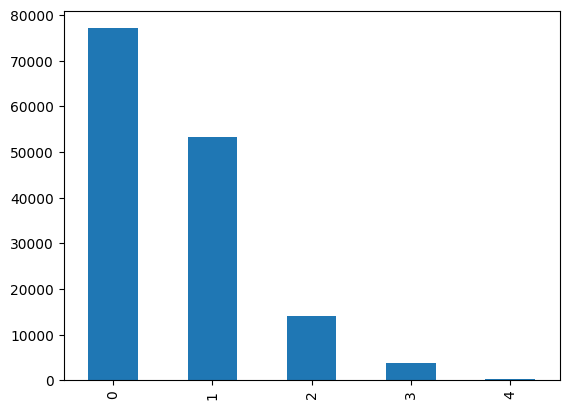

In [17]:
#code to augment some classes
normalized_df['class'].value_counts().plot(kind = "bar")

In [18]:
minority_classes = [ 2 , 3 , 4]
mask = normalized_df['class'].isin(minority_classes)
minority_df = normalized_df[mask]
minority_df

,land,logged_in,is_host_login,is_guest_login,class,difficulty_level,duration,src_bytes,dst_bytes,wrong_fragment,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
13,0,1,0,0,3,15,-0.112481,-0.007375,-0.004614,-0.085488,...,0,0,0,0,0,0,0,0,1,0
17,0,0,0,0,2,18,-0.112481,-0.007433,-0.004614,-0.085488,...,0,0,0,0,0,0,0,0,1,0
30,0,0,0,0,2,17,-0.112481,-0.007435,-0.004614,-0.085488,...,0,0,0,0,0,0,0,0,1,0
33,0,0,0,0,2,20,-0.112481,-0.007436,-0.004614,-0.085488,...,1,0,0,0,0,0,0,0,0,0
48,0,1,0,0,3,12,-0.112481,-0.007375,-0.004614,-0.085488,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22524,0,1,0,0,4,4,-0.106386,-0.007428,-0.004556,-0.085488,...,0,0,0,0,0,0,0,0,1,0
22543,0,0,0,0,2,14,-0.112481,-0.007436,-0.004614,-0.085488,...,1,0,0,0,0,0,0,0,0,0
22546,0,0,0,0,2,17,-0.112481,-0.007436,-0.004614,-0.085488,...,0,0,0,0,1,0,0,0,0,0
22547,0,0,0,0,2,17,-0.112481,-0.007436,-0.004614,-0.085488,...,1,0,0,0,0,0,0,0,0,0


In [19]:
#code--
from imblearn.over_sampling import SMOTE

minority = minority_df.drop(['difficulty_level'], axis = 1)
xm = minority.drop(['class'], axis = 1)
ym = minority['class']

smote = SMOTE()
augmented_x, augmented_y = smote.fit_resample(xm.values,ym.values.astype('int'))


<Axes: >

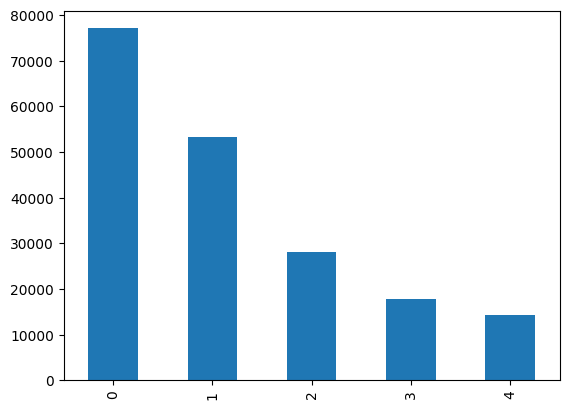

In [20]:
original_df = normalized_df
xmc = pd.DataFrame(xm).columns
ymc = pd.DataFrame(ym).columns
augmented = pd.concat([pd.DataFrame(augmented_x, columns=xmc), pd.DataFrame(augmented_y, columns = ymc)], axis = 1)
normalized_df = pd.concat([pd.DataFrame(normalized_df.drop(['difficulty_level'], axis = 1)), augmented])
normalized_df['class'].value_counts().plot(kind = "bar")


##### Data analysing

In [21]:
print("Data Cleaning process: \n")
# instances dupliquées 
print("number of duplicated instances :",normalized_df.duplicated().sum())
#suppression 
normalized_df = normalized_df.drop_duplicates()

print("\n")
# verifier les valeurs manquantes
missing_values = normalized_df.isnull().any(axis=1)

if missing_values.any():
    print("There are instances with missing values:")
    print(normalized_df[missing_values])
else:
    print("There are no instances with missing values.")

# colones ayant la meme valuers
unique_counts = normalized_df.nunique()
columns = unique_counts[unique_counts == 1].index.tolist()
print("\ncolones avec les memes valeurs: ",columns)
print("\n")
# paires d'attributs ayant une correlation elvée
# Calculate the correlation matrix
corr_matrix = normalized_df.corr()

# Find unique attribute pairs with correlation above 0.90
high_corr_pairs = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.90:
            pair = (corr_matrix.columns[i], corr_matrix.columns[j])
            high_corr_pairs.add(tuple(sorted(pair)))

# Print the unique attribute pairs with high correlation
count = 0
for pair in high_corr_pairs:
    count +=1
    print(f"Attributes '{pair[0]}' and '{pair[1]}' have correlation above 0.90.")
print (count)

Data Cleaning process: 

number of duplicated instances : 18737


There are no instances with missing values.

colones avec les memes valeurs:  ['num_outbound_cmds']




<ipython-input-21-031bb403cfef>:24: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = normalized_df.corr()


Attributes 'flag_S0' and 'srv_serror_rate' have correlation above 0.90.
Attributes 'dst_host_serror_rate' and 'flag_S0' have correlation above 0.90.
Attributes 'serror_rate' and 'srv_serror_rate' have correlation above 0.90.
Attributes 'flag_S0' and 'serror_rate' have correlation above 0.90.
Attributes 'dst_host_serror_rate' and 'srv_serror_rate' have correlation above 0.90.
Attributes 'dst_host_serror_rate' and 'dst_host_srv_serror_rate' have correlation above 0.90.
Attributes 'dst_host_srv_serror_rate' and 'flag_S0' have correlation above 0.90.
Attributes 'rerror_rate' and 'srv_rerror_rate' have correlation above 0.90.
Attributes 'dst_host_srv_rerror_rate' and 'srv_rerror_rate' have correlation above 0.90.
Attributes 'dst_host_serror_rate' and 'serror_rate' have correlation above 0.90.
Attributes 'dst_host_srv_serror_rate' and 'srv_serror_rate' have correlation above 0.90.
Attributes 'num_compromised' and 'num_root' have correlation above 0.90.
Attributes 'dst_host_srv_rerror_rate' a

##### Data Cleaning

In [22]:
# List of columns to remove
columns_to_remove = ['serror_rate', 'num_compromised', 'flag_S0','dst_host_rerror_rate',
                     'dst_host_srv_rerror_rate', 'dst_host_serror_rate',
                     'rerror_rate', 'dst_host_srv_serror_rate', 'num_outbound_cmds']

# Remove the specified columns
normalized_df.drop(columns = columns_to_remove, axis=1, inplace=True)

In [23]:
pd.DataFrame(normalized_df)['class'].value_counts()


0    76967
1    52987
4    14076
3    14043
2    13934
Name: class, dtype: int64

In [24]:

normalized_df = normalized_df.sample(frac = 1, random_state = 42)
normalized_df = normalized_df.reset_index(drop = True)


##### Feature selection (reduction) PCA

In [25]:
#Extraction des X et Y
x = normalized_df.drop(['class'], axis = 1).values
y = normalized_df['class'].values.astype('int')

#initialisation PCA
pca = PCA(n_components = 108)
pca = pca.fit(x)
x_r = pca.transform(x)

print("# Of original features: ", x.shape[1])
print("# Features after reduction: ", x_r.shape[1])




# Of original features:  112
# Features after reduction:  108


In [26]:
#Training splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42)

#reduced features splits
xr_train, xr_test, yr_train, yr_test = train_test_split(x_r, y, test_size = 0.3, random_state = 42)
xr_val, xr_test, yr_val, yr_test = train_test_split(xr_test, yr_test, test_size = 0.5, random_state = 42)

print("x_train shape : ", x_train.shape)
print("y_train shape : ", y_train.shape)

print("x_test shape : ", x_test.shape)
print("y_test shape : ", y_test.shape)

x_train shape :  (120404, 112)
y_train shape :  (120404,)
x_test shape :  (25802, 112)
y_test shape :  (25802,)


#Models and evaluation


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, X_test, y_true):
    # Step 2: Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Step 3: Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Step 4: Calculate precision
    precision = precision_score(y_true, y_pred, average='weighted')

    # Step 5: Calculate F1-score
    f1score = f1_score(y_true, y_pred, average='weighted')

    # Step 6: Calculate Recall
    recall = recall_score(y_true, y_pred, average='weighted')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1score)

    # Generate the classification report
    print("\n\n",classification_report(y_test, y_pred))

    # Step 6: Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)


    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(4, 3))

    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

    # Set labels and title
    classes = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']  
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

    # Set x-axis and y-axis tick labels
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)

    # Rotate the tick labels for better visibility
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Display the plot
    plt.show()

# Models


### CNN

In [28]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 110, 32)           128       
                                                                 
 conv1d_1 (Conv1D)           (None, 108, 64)           6208      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 54, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 54, 64)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 52, 128)           24704     
                                                                 
 conv1d_3 (Conv1D)           (None, 50, 128)           49280     
                                                        

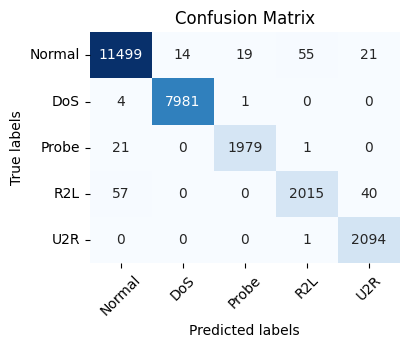

In [29]:


CNN = Sequential()
CNN.add(Conv1D(32, 3, activation='relu', input_shape=(112,1)))
CNN.add(Conv1D(64, 3, activation='relu'))
CNN.add(MaxPooling1D(2))
CNN.add(Dropout(0.2))
CNN.add(Conv1D(128, 3, activation='relu'))
CNN.add(Conv1D(128, 3, activation='relu'))
CNN.add(MaxPooling1D(2))
CNN.add(Dropout(0.2))
CNN.add(Flatten())
CNN.add(Dense(256, activation='relu'))
CNN.add(Dropout(0.5))
CNN.add(Dense(5, activation='softmax'))
CNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN.summary()

# Train the CNN
history = CNN.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val),batch_size = 64)
evaluate_model(CNN, x_test, y_test)

In [30]:
#path = "/content/drive/MyDrive/Colab Notebooks/h5 files/"

In [31]:

#CNN.save(path +"Cnn precision_99 input_113 .h5")

### cnn lstm

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 112, 128)          256       
                                                                 
 conv1d_4 (Conv1D)           (None, 110, 64)           24640     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 55, 128)           98816     
                                                                 
 dropout_3 (Dropout)         (None, 55, 128)           0         
                                                                 
 flatten_1 (Flatten)         (None, 7040)              0         
                                                      

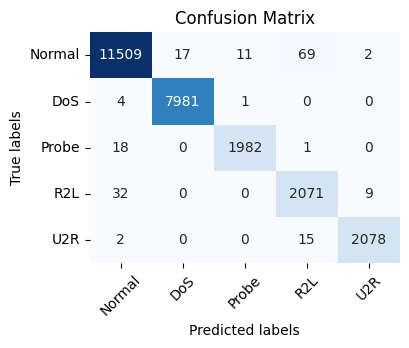

In [32]:

model2 = Sequential()
model2.add(Dense(128, activation='relu', input_shape=(112, 1)))
model2.add(Conv1D(64, kernel_size=3, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(LSTM(128, return_sequences=True))
model2.add(Dropout(0.3))
model2.add(Flatten())
model2.add(Dense(32, activation='relu'))
model2.add(Dense(5, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Compile the model2
model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()
# Train the model2
history = model2.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val),batch_size = 64)
evaluate_model(model2, x_test, y_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 112, 32)           64        
                                                                 
 conv1d_5 (Conv1D)           (None, 110, 128)          12416     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 55, 128)          0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 55, 128)           131584    
                                                                 
 dropout_4 (Dropout)         (None, 55, 128)           0         
                                                                 
 flatten_2 (Flatten)         (None, 7040)              0         
                                                      

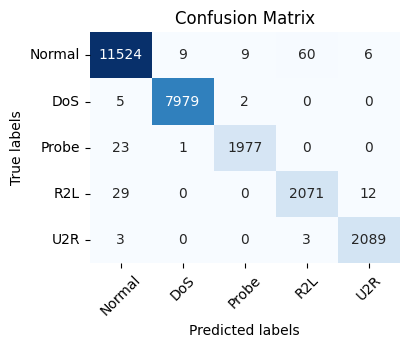

In [33]:

model3 = Sequential()
model3.add(Dense(32, activation='relu', input_shape=(112, 1)))
model3.add(Conv1D(128, kernel_size=3, activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(LSTM(128, return_sequences=True))
model3.add(Dropout(0.3))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(5, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Compile the model3
model3.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model3.summary()
# Train the model3
history = model3.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val),batch_size = 64)
evaluate_model(model3, x_test, y_test)

### LSTM

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 112, 32)           64        
                                                                 
 dense_12 (Dense)            (None, 112, 128)          4224      
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 128)               8320      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 5)                

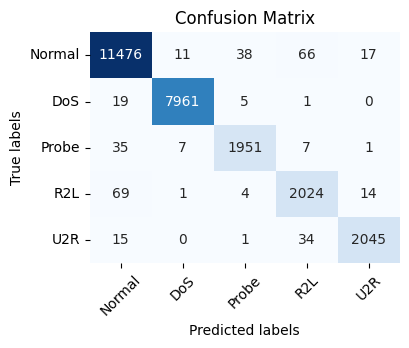

In [37]:
lstm = Sequential()
lstm.add(Dense(32, activation='relu', input_shape=(112,1)))
lstm.add(Dense(128, activation ='relu'))
lstm.add(LSTM(128, return_sequences=False))
lstm.add(Dense(64, activation='relu'))
lstm.add(Dense(128, activation='relu'))
lstm.add(Dropout(0.5))
lstm.add(Dense(5, activation='softmax'))
    
lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm.summary()

# Train the cnn_lstm
history = lstm.fit(x_train, y_train, epochs=50, validation_data=(x_val,y_val),batch_size = 64)
evaluate_model(lstm, x_test, y_test)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 112)               12656     
                                                                 
 dense_17 (Dense)            (None, 64)                7232      
                                                                 
 dense_18 (Dense)            (None, 128)               8320      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 5)                 325       
                                                                 
Total params: 36,789
Trainable params: 36,789
Non-trai

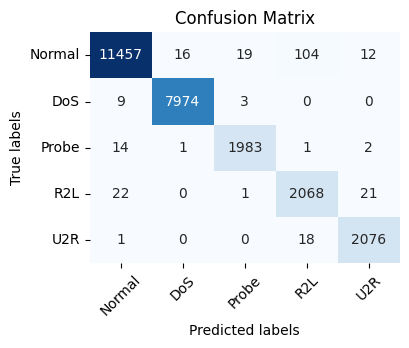

In [38]:
DNN = Sequential()
DNN.add(Dense(112, input_shape=(112,), activation='relu'))
DNN.add(Dense(64, activation='relu'))
DNN.add(Dense(128, activation='relu'))
DNN.add(Dropout(0.5))
DNN.add(Dense(64, activation='relu'))
DNN.add(Dense(5, activation='softmax'))

DNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
DNN.summary()

# Train the cnn_lstm
history = DNN.fit(x_train, y_train, epochs=50, validation_data=(x_val,y_val),batch_size = 64)
evaluate_model(DNN, x_test, y_test)

In [36]:
path ="/content/drive/MyDrive/Colab Notebooks/h5 files/"
model3.save(path +"Cnn_lstm input_113 the best of all time 99-37.h5")